<a href="https://colab.research.google.com/github/kitouras/handwritten-text-segmentation/blob/main/segmentation_catalyst.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports


In [ ]:
!pip install -U git+https://github.com/albu/albumentations > /dev/null && echo "Albumentations is successfully installed!"
import albumentations as A

  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-dh94aw8w
Albumentations is successfully installed!


In [ ]:
!pip install -U catalyst > /dev/null && echo "Catalyst is successfully installed!"

Catalyst is successfully installed!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torchvision.transforms.functional as TF
import torch
import torch.nn as nn
from torchvision import transforms
import numpy as np
import cv2
import pandas as pd
import json
import os
import ast
from torch.utils.data import Dataset
from tqdm import tqdm
from torch.utils.data import DataLoader
from albumentations.pytorch.transforms import ToTensorV2
from albumentations.augmentations.transforms import GaussianBlur, ToGray
from torch import optim
import torchvision
import math
import random
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import pdb
import torch.nn.functional as F
from catalyst import dl, metrics
from catalyst.contrib.nn import TrevskyLoss

In [ ]:
%%shell

wget https://storage.googleapis.com/handwritten_rus/SEGMENTATION/comptech_segmentation_handwritten.zip .
wget https://storage.googleapis.com/handwritten_rus/SEGMENTATION/images.tsv .
unzip comptech_segmentation_handwritten.zip

--2021-07-16 11:36:24--  https://storage.googleapis.com/handwritten_rus/SEGMENTATION/comptech_segmentation_handwritten.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.189.128, 108.177.97.128, 74.125.23.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.189.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 63756948 (61M) [application/x-zip-compressed]
Saving to: ‘comptech_segmentation_handwritten.zip’

comptech_segmentati 100%[===================>]  60.80M   212MB/s    in 0.3s    

2021-07-16 11:36:25 (212 MB/s) - ‘comptech_segmentation_handwritten.zip’ saved [63756948/63756948]

--2021-07-16 11:36:25--  http://./
Resolving . (.)... failed: No address associated with hostname.
wget: unable to resolve host address ‘.’
FINISHED --2021-07-16 11:36:25--
Total wall clock time: 0.6s
Downloaded: 1 files, 61M in 0.3s (212 MB/s)
--2021-07-16 11:36:25--  https://storage.googleapis.com/handwritten_rus/SEGMENTATION/image

# Hyperparameters


In [ ]:
# Hyperparameters etc.
LEARNING_RATE = 1e-4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 2
NUM_EPOCHS = 30
NUM_WORKERS = 2
IMAGE_HEIGHT = 768 
IMAGE_WIDTH = 768 
PIN_MEMORY = True
LOAD_MODEL = True
TRAIN_IMG_DIR = "/content/train_images/"
TRAIN_MASK_DIR = "/content/train_masks/"
VAL_IMG_DIR = "/content/valid_images/"
VAL_MASK_DIR = "/content/valid_masks/"

# Data Preprocessing

In [ ]:
data_path = r'comptech_segmentation_handwritten/images/'
data_path_unlabeled = r'comptech_segmentation_handwritten/unlabeled_images/'
data = pd.read_csv("images.tsv", sep='\t')
output_results = data["OUTPUT:result"].values
input_images = data["INPUT:image"].values
! mkdir /content/train_masks
! mkdir /content/train_images
! mkdir /content/valid_masks
! mkdir /content/valid_images

In [ ]:
image_count = len(os.listdir(data_path))
data_indices = np.arange(image_count)
np.random.shuffle(data_indices)
train_indices = data_indices[:round(len(data_indices)*0.8)]

for image_idx, image in enumerate(os.listdir(data_path)):
  img = cv2.imread(os.path.join(data_path,image))
  im_name = f'/comptech-segmentation1/{image}'
  height = img.shape[0]
  width = img.shape[1]
  cond = data[data['INPUT:image'] == im_name]
  mask = np.zeros((height,width),dtype=np.uint8)


  for shape in cond['OUTPUT:result']:
    shape = ast.literal_eval(shape)
    if shape[0]['type'] == 'polygon':
      pass
    else:
      for s in shape:
        l0_p1 = s['data']['p1']
        l0_p2 = s['data']['p2']
        start = [
            int(width * l0_p1['x']),
            int(height * l0_p1['y'])
        ]
        end = [int(width * l0_p2['x']), int(height * l0_p2['y'])]
        if start[0] > end[0]:
          start[0], end[0] = end[0], start[0]
        if start[1] > end[1]:
          start[1], end[1] = end[1], start[1]
        start, end = tuple(start),  tuple(end)
        try:
          mask[start[1]:end[1], start[0]:end[0]] = 255
        except Exception as exc:
          print('Error')
          continue
      if image_idx in train_indices:
        cv2.imwrite(f'{TRAIN_MASK_DIR}{image}', mask)
        cv2.imwrite(f'{TRAIN_IMG_DIR}{image}', img)
      else:
        cv2.imwrite(f'{VAL_MASK_DIR}{image}', mask)
        cv2.imwrite(f'{VAL_IMG_DIR}{image}', img)

In [ ]:
class SegDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img_path = os.path.join(self.image_dir, self.images[index])
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask_path = os.path.join(self.mask_dir, self.images[index])
        mask = cv2.imread(mask_path)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        ret,mask = cv2.threshold(mask,127,255,cv2.THRESH_BINARY)
        mask[mask == 255.0] = 1.0

        if self.transform is not None:
            augmentations = self.transform(image=image, mask=mask)
            image = augmentations["image"]
            mask = augmentations["mask"]

        return image, mask

In [ ]:
train_transform = A.Compose(
        [
            A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
            A.Rotate(limit=15, p=1),
            A.RandomSizedCrop(min_max_height=(IMAGE_HEIGHT//2, IMAGE_HEIGHT), height=IMAGE_HEIGHT, width=IMAGE_WIDTH, p=0.5),
            A.RandomRotate90(p=1),
            A.CLAHE(p=0.8),
            A.RandomBrightnessContrast(p=0.8),    
            A.RandomGamma(p=0.8),
            A.Normalize(),
            GaussianBlur(p=1, blur_limit=7),
            ToGray(p=1),
            ToTensorV2(),
        ],
    )
val_transform = A.Compose(
    [
            A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
            A.Normalize(),
            GaussianBlur(p=1, blur_limit=7),
            ToGray(p=1),
            ToTensorV2(),
        ],
)

/usr/local/lib/python3.7/dist-packages/albumentations/augmentations/transforms.py:1897: UserWarning: blur_limit and sigma_limit minimum value can not be both equal to 0. blur_limit minimum value changed to 3.
  "blur_limit and sigma_limit minimum value can not be both equal to 0. "


In [ ]:
train_ds = SegDataset(
        image_dir=TRAIN_IMG_DIR,
        mask_dir=TRAIN_MASK_DIR,
        transform=train_transform,
    )
val_ds = SegDataset(
        image_dir=VAL_IMG_DIR,
        mask_dir=VAL_MASK_DIR,
        transform=val_transform,
)

In [ ]:
loaders = {
    "train": DataLoader(
      train_ds,
      batch_size=BATCH_SIZE,
      num_workers=NUM_WORKERS,
      pin_memory=PIN_MEMORY,
      shuffle=True,
    ),
    "valid": DataLoader(
      val_ds,
      batch_size=BATCH_SIZE,
      num_workers=NUM_WORKERS,
      pin_memory=PIN_MEMORY,
      shuffle=True,
    )
}

# Model

In [ ]:
class GaborFilters(nn.Module):
    def __init__(self,
                 in_channels,
                 n_sigmas=3,
                 n_lambdas=4,
                 n_gammas=1,
                 n_thetas=7,
                 kernel_radius=15,
                 rotation_invariant=True
                 ):
        super().__init__()
        self.in_channels = in_channels
        kernel_size = kernel_radius * 2 + 1
        self.kernel_size = kernel_size
        self.kernel_radius = kernel_radius
        self.n_thetas = n_thetas
        self.rotation_invariant = rotation_invariant

        def make_param(in_channels, values, requires_grad=True, dtype=None):
            if dtype is None:
                dtype = 'float32'
            values = np.require(values, dtype=dtype)
            n = in_channels * len(values)
            data = torch.from_numpy(values).view(1, -1)
            data = data.repeat(in_channels, 1)
            return torch.nn.Parameter(data=data, requires_grad=requires_grad)

        # build all learnable parameters
        self.sigmas = make_param(in_channels, 2 ** np.arange(n_sigmas) * 2)
        self.lambdas = make_param(in_channels, 2 ** np.arange(n_lambdas) * 4.0)
        self.gammas = make_param(in_channels, np.ones(n_gammas) * 0.5)
        self.psis = make_param(in_channels, np.array([0, math.pi / 2.0]))

        thetas = np.linspace(0.0, 2.0 * math.pi, num=n_thetas, endpoint=False)
        thetas = torch.from_numpy(thetas).float()
        self.register_buffer('thetas', thetas)

        indices = torch.arange(kernel_size, dtype=torch.float32) - (kernel_size - 1) / 2
        self.register_buffer('indices', indices)

        # number of channels after the conv
        self._n_channels_post_conv = self.in_channels * self.sigmas.shape[1] * \
                                     self.lambdas.shape[1] * self.gammas.shape[1] * \
                                     self.psis.shape[1] * self.thetas.shape[0]

    def make_gabor_filters(self):

        sigmas = self.sigmas
        lambdas = self.lambdas
        gammas = self.gammas
        psis = self.psis
        thetas = self.thetas
        y = self.indices
        x = self.indices

        in_channels = sigmas.shape[0]
        assert in_channels == lambdas.shape[0]
        assert in_channels == gammas.shape[0]

        kernel_size = y.shape[0], x.shape[0]

        sigmas = sigmas.view(in_channels, sigmas.shape[1], 1, 1, 1, 1, 1, 1)
        lambdas = lambdas.view(in_channels, 1, lambdas.shape[1], 1, 1, 1, 1, 1)
        gammas = gammas.view(in_channels, 1, 1, gammas.shape[1], 1, 1, 1, 1)
        psis = psis.view(in_channels, 1, 1, 1, psis.shape[1], 1, 1, 1)

        thetas = thetas.view(1, 1, 1, 1, 1, thetas.shape[0], 1, 1)
        y = y.view(1, 1, 1, 1, 1, 1, y.shape[0], 1)
        x = x.view(1, 1, 1, 1, 1, 1, 1, x.shape[0])

        sigma_x = sigmas
        sigma_y = sigmas / gammas

        sin_t = torch.sin(thetas)
        cos_t = torch.cos(thetas)
        y_theta = -x * sin_t + y * cos_t
        x_theta = x * cos_t + y * sin_t

        gb = torch.exp(-.5 * (x_theta ** 2 / sigma_x ** 2 + y_theta ** 2 / sigma_y ** 2)) \
             * torch.cos(2.0 * math.pi * x_theta / lambdas + psis)

        gb = gb.view(-1, kernel_size[0], kernel_size[1])
        if torch.cuda.is_available():
            gb = gb.to('cuda')
        return gb

    def forward(self, x):
        batch_size = x.size(0)
        sy = x.size(2)
        sx = x.size(3)
        gb = self.make_gabor_filters()

        assert gb.shape[0] == self._n_channels_post_conv
        assert gb.shape[1] == self.kernel_size
        assert gb.shape[2] == self.kernel_size
        gb = gb.view(self._n_channels_post_conv, 1, self.kernel_size, self.kernel_size)

        res = nn.functional.conv2d(input=x, weight=gb,
                                   padding=self.kernel_radius, groups=self.in_channels)

        if self.rotation_invariant:
            res = res.view(batch_size, self.in_channels, -1, self.n_thetas, sy, sx)
            res, _ = res.max(dim=3)

        res = res.view(batch_size, -1, sy, sx)

        return res


In [ ]:
class Morphology(nn.Module):
    '''
    Base class for morpholigical operators 
    For now, only supports stride=1, dilation=1, kernel_size H==W, and padding='same'.
    '''

    def __init__(self, in_channels, out_channels, kernel_size=5, soft_max=True, beta=15, type=None):
        '''
        in_channels: scalar
        out_channels: scalar, the number of the morphological neure. 
        kernel_size: scalar, the spatial size of the morphological neure.
        soft_max: bool, using the soft max rather the torch.max(), ref: Dense Morphological Networks: An Universal Function Approximator (Mondal et al. (2019)).
        beta: scalar, used by soft_max.
        type: str, dilation2d or erosion2d.
        '''
        super(Morphology, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.soft_max = soft_max
        self.beta = beta
        self.type = type

        self.weight = nn.Parameter(torch.zeros(out_channels, in_channels, kernel_size, kernel_size), requires_grad=True)
        self.unfold = nn.Unfold(kernel_size, dilation=1, padding=0, stride=1)

    def forward(self, x):
        '''
        x: tensor of shape (B,C,H,W)
        '''
        # padding
        x = fixed_padding(x, self.kernel_size, dilation=1)

        # unfold
        x = self.unfold(x)  # (B, Cin*kH*kW, L), where L is the numbers of patches
        x = x.unsqueeze(1)  # (B, 1, Cin*kH*kW, L)
        L = x.size(-1)
        L_sqrt = int(math.sqrt(L))

        # erosion
        weight = self.weight.view(self.out_channels, -1)  # (Cout, Cin*kH*kW)
        weight = weight.unsqueeze(0).unsqueeze(-1)  # (1, Cout, Cin*kH*kW, 1)

        if self.type == 'erosion2d':
            x = weight - x  # (B, Cout, Cin*kH*kW, L)
        elif self.type == 'dilation2d':
            x = weight + x  # (B, Cout, Cin*kH*kW, L)
        else:
            raise ValueError

        if not self.soft_max:
            x, _ = torch.max(x, dim=2, keepdim=False)  # (B, Cout, L)
        else:
            x = torch.logsumexp(x * self.beta, dim=2, keepdim=False) / self.beta  # (B, Cout, L)

        if self.type == 'erosion2d':
            x = -1 * x

        # instead of fold, we use view to avoid copy
        x = x.view(-1, self.out_channels, L_sqrt, L_sqrt)  # (B, Cout, L/2, L/2)

        return x


class Dilation2d(Morphology):
    def __init__(self, in_channels, out_channels, kernel_size=5, soft_max=True, beta=20):
        super(Dilation2d, self).__init__(in_channels, out_channels, kernel_size, soft_max, beta, 'dilation2d')


class Erosion2d(Morphology):
    def __init__(self, in_channels, out_channels, kernel_size=5, soft_max=True, beta=20):
        super(Erosion2d, self).__init__(in_channels, out_channels, kernel_size, soft_max, beta, 'erosion2d')


def fixed_padding(inputs, kernel_size, dilation):
    kernel_size_effective = kernel_size + (kernel_size - 1) * (dilation - 1)
    pad_total = kernel_size_effective - 1
    pad_beg = pad_total // 2
    pad_end = pad_total - pad_beg
    padded_inputs = F.pad(inputs, (pad_beg, pad_end, pad_beg, pad_end))
    return padded_inputs

In [ ]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)


class UNET(nn.Module):
    def __init__(
            self, in_channels=3, out_channels=1, features=[128, 256, 512],
    ):
        super(UNET, self).__init__()
        self.gabor = GaborFilters(in_channels)
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of UNET
        in_channels = 72  # gabor's filter output channels
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature * 2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature * 2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1] * 2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)
        self.erode = Erosion2d(out_channels, out_channels)
        self.dilate = Dilation2d(out_channels, out_channels)

    def forward(self, x):
        skip_connections = []
        x = x.float()
        x = self.gabor(x)
        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)
        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx // 2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx + 1](concat_skip)

        x = self.final_conv(x)
        for _ in range(2):
            x = self.erode(x)
            x = self.dilate(x)
        x = self.dilate(x)
        return x

# Utils

In [ ]:
def get_accuracy(logits, y):
  preds = torch.sigmoid(logits)
  preds = (preds > 0.5).float()
  num_correct = (preds == y).sum()
  num_pixels = torch.numel(preds)
  return num_correct/num_pixels*100

In [ ]:
class CustomRunner(dl.Runner):
    def predict_batch(self, batch):
        x = self.model(batch[0].to(self.device))
        x = torch.sigmoid(x)
        return (x > 0.5).float()

    def on_loader_start(self, runner):
        super().on_loader_start(runner)
        self.meters = {
            key: metrics.AdditiveValueMetric(compute_on_call=False)
            for key in ["loss", "accuracy"]
        }

    def handle_batch(self, batch):
        # model train/valid step
        # unpack the batch
        x, y = batch
        y = y.float().unsqueeze(1)
        # run model forward pass
        logits = self.model(x)
        # compute the loss
        loss = self.criterion(logits, y)
        # compute the metrics
        accuracy = get_accuracy(logits, y)
        # log metrics
        self.batch_metrics.update(
            {"loss": loss, "accuracy": accuracy}
        )
        for key in ["loss", "accuracy"]:
            self.meters[key].update(self.batch_metrics[key].item(), self.batch_size)
        # run model backward pass
        if self.is_train_loader:
            loss.backward()
            self.optimizer.step()
            self.optimizer.zero_grad()

    def on_loader_end(self, runner):
        for key in ["loss", "accuracy"]:
            self.loader_metrics[key] = self.meters[key].compute()[0]
        super().on_loader_end(runner)

In [ ]:
ALPHA = 0.7
BETA = 0.3

class TverskyLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(TverskyLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1, alpha=ALPHA, beta=BETA):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = torch.sigmoid(inputs)  
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        ones_tensor = 1 + 1e-6
        #True Positives, False Positives & False Negatives
        TP = torch.sum(inputs * targets)    
        FP = torch.sum((-targets + ones_tensor) * inputs)
        FN = torch.sum(targets * (-inputs + ones_tensor))
        #print('TP = {TP}, FP = {FP}, FN = {FN}'.format(TP=TP, FP=FP, FN=FN))
       
        Tversky = (TP + smooth) / (TP + alpha*FP + beta*FN + smooth)  
        
        return 1 - Tversky
        

In [ ]:
def save_checkpoint(state, filename="/content/drive/MyDrive/checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)

def load_checkpoint(model, filename="/content/drive/MyDrive/checkpoint.pth.tar"):
    print("=> Loading checkpoint")
    checkpoint = torch.load(filename)
    model.load_state_dict(checkpoint["state_dict"])

# Train

In [ ]:
model = UNET(in_channels=3, out_channels=1).to(DEVICE)
criterion = TverskyLoss()

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [ ]:
runner = CustomRunner()

In [ ]:
runner.train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    loaders=loaders,
    num_epochs=15,
    logdir="./logdir",
    valid_loader="valid",
    valid_metric="loss",
    minimize_valid_metric=True,
    verbose=True,
)



train (1/15) accuracy: 85.08961038028492 | loss: 0.16272292768254



valid (1/15) accuracy: 74.71103057861328 | loss: 0.27092450857162476
* Epoch (1/15) 



train (2/15) accuracy: 86.33573285271139 | loss: 0.16755663296755618



valid (2/15) accuracy: 77.30391082763671 | loss: 0.24740673303604127
* Epoch (2/15) 



train (3/15) accuracy: 83.87078318876378 | loss: 0.16824531204560222



valid (3/15) accuracy: 74.2622573852539 | loss: 0.2770051956176758
* Epoch (3/15) 



train (4/15) accuracy: 84.86509659711054 | loss: 0.16749887606676883



valid (4/15) accuracy: 76.25871887207032 | loss: 0.2524246335029602
* Epoch (4/15) 



train (5/15) accuracy: 83.97098227108228 | loss: 0.15848411532009346



valid (5/15) accuracy: 71.35345687866212 | loss: 0.34204537868499757
* Epoch (5/15) 



train (6/15) accuracy: 83.8028761919807 | loss: 0.18610765302882476



valid (6/15) accuracy: 63.592970275878905 | loss: 0.624893319606781
* Epoch (6/15) 



train (7/15) accuracy: 85.07558710434857 | loss: 0.1611398738973281



valid (7/15) accuracy: 67.21523513793946 | loss: 0.44686093330383303
* Epoch (7/15) 



train (8/15) accuracy: 84.00521042767693 | loss: 0.17434277604607976



valid (8/15) accuracy: 78.13659973144532 | loss: 0.2407209873199463
* Epoch (8/15) 



train (9/15) accuracy: 84.97369384765625 | loss: 0.16200882196426392



valid (9/15) accuracy: 73.83653259277344 | loss: 0.2855760812759399
* Epoch (9/15) 



train (10/15) accuracy: 84.8868376787971 | loss: 0.18017228911904729



valid (10/15) accuracy: 79.14384460449219 | loss: 0.21417083740234374
* Epoch (10/15) 



train (11/15) accuracy: 85.1198995253619 | loss: 0.16475632260827455



valid (11/15) accuracy: 72.2612518310547 | loss: 0.3058588743209839
* Epoch (11/15) 



train (12/15) accuracy: 83.3782231947955 | loss: 0.1747046148075777



valid (12/15) accuracy: 70.03618469238282 | loss: 0.323973023891449
* Epoch (12/15) 



train (13/15) accuracy: 81.88446673224955 | loss: 0.18316062408335068



valid (13/15) accuracy: 67.81900939941406 | loss: 0.5662787914276123
* Epoch (13/15) 



train (14/15) accuracy: 82.39094767850987 | loss: 0.18291639931061687



valid (14/15) accuracy: 66.04325866699219 | loss: 0.49601473808288576
* Epoch (14/15) 



train (15/15) accuracy: 85.35725806741154 | loss: 0.15368030702366547



valid (15/15) accuracy: 78.32953643798828 | loss: 0.22727111577987671
* Epoch (15/15) 
Top best models:
logdir/checkpoints/train.10.pth	0.2142


In [ ]:
train_losses = pd.read_csv('/content/logdir/logs/train.csv')
valid_losses = pd.read_csv('/content/logdir/logs/valid.csv')

In [ ]:
plt.plot(train_losses['step'], train_losses['loss'])

AttributeError: ignored

In [ ]:
valid_logits = []
for logits in runner.predict_loader(loader=loaders["valid"]):
    valid_logits.append(logits.detach().cpu().numpy().transpose((0, 2, 3, 1)))

In [ ]:
test_img = val_ds[0][0].detach().cpu().numpy().transpose((1, 2, 0))
_, test_img = cv2.threshold(test_img,2,255,cv2.THRESH_BINARY)
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2GRAY)

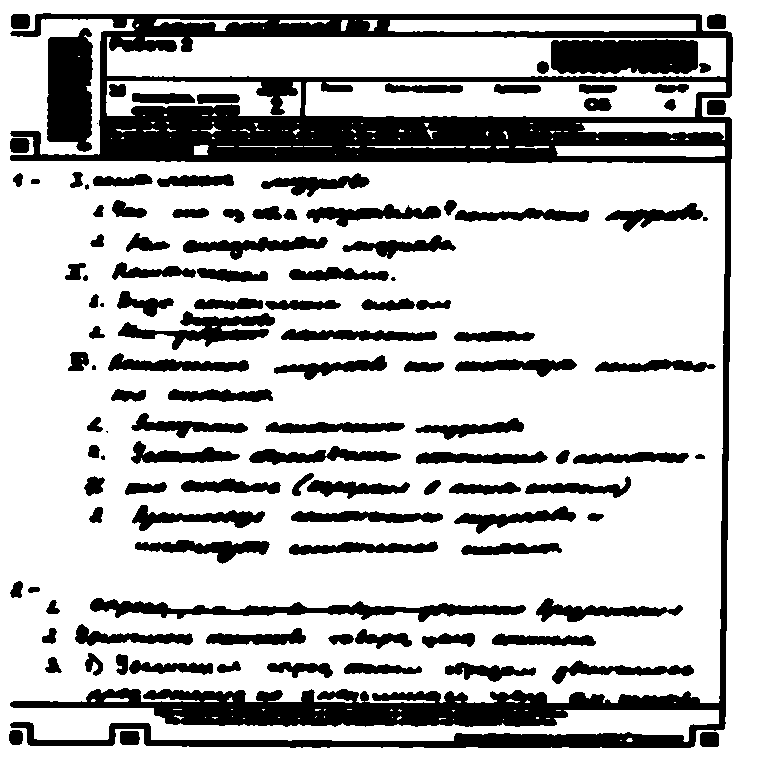

In [ ]:
cv2_imshow(test_img)

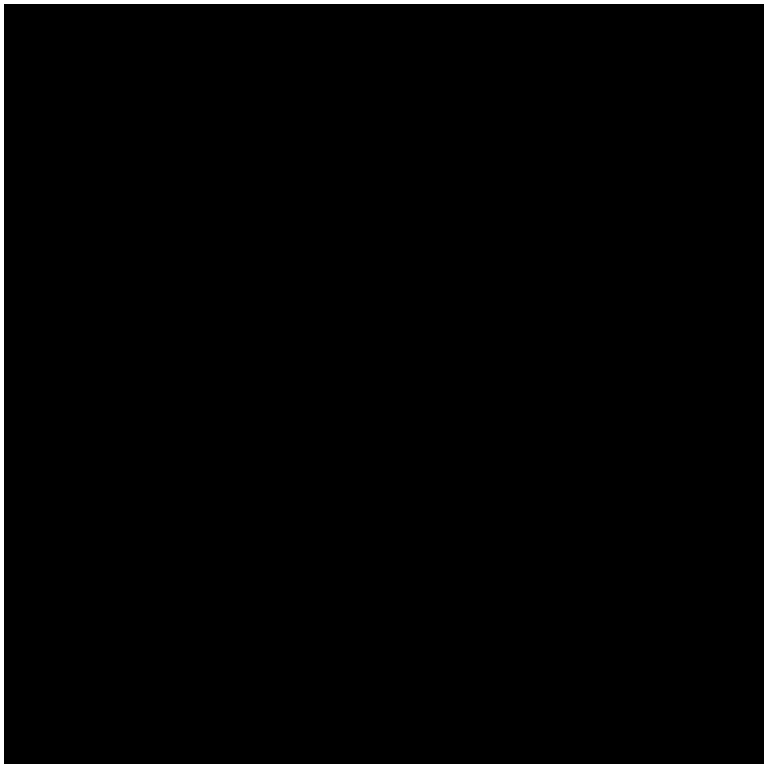

In [ ]:
_, test_mask = cv2.threshold(valid_logits[0][0],0.5,255,cv2.THRESH_BINARY)
cv2_imshow(test_mask)

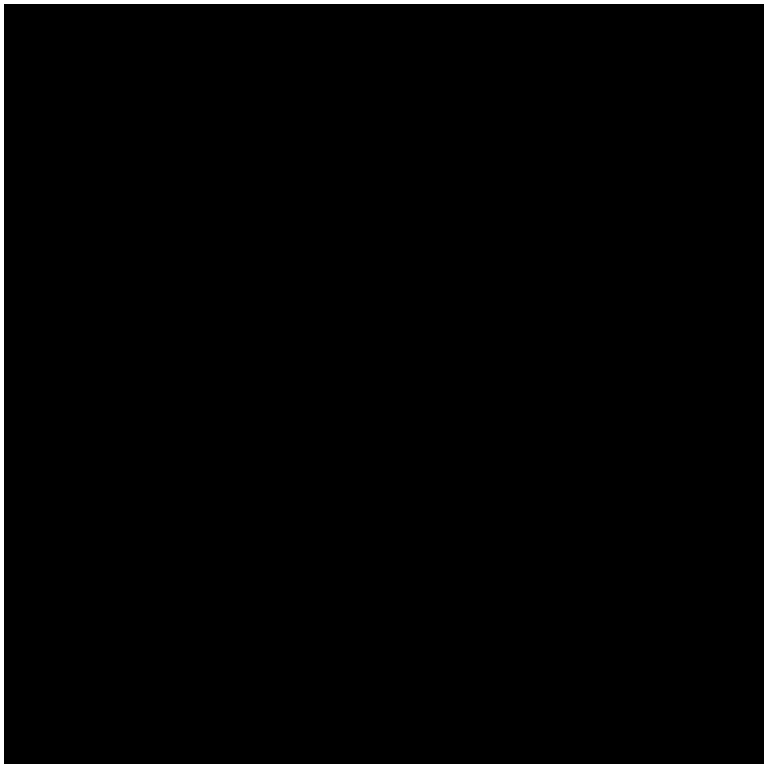

In [ ]:
test_multiply = cv2.multiply(test_img, test_mask)
cv2_imshow(test_multiply)